In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [189]:
def plot_loss(losses, epochs):
    fig, ax = plt.subplots()
    ax.plot([i for i in range(epochs)], losses)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Mean Squared Error')

def plot_image(image):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    plt.show()

## Data Loading

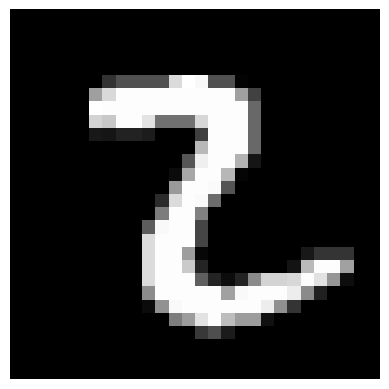

In [207]:
# define a transform to convert the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# download and load the training dataset
train_dataset = torchvision.datasets.MNIST(
    root='../data/hidden', 
    train=True,
    download=True,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    num_workers=0,
    shuffle=True
)

image, _ = next(iter(train_loader))
plot_image(image.squeeze())

## Model

In [184]:
image_width = 28
image_height = 28
learning_rate = 0.005
y_dim = 300

In [145]:
class FEBAM(nn.Module):
    def __init__(self, x_dim, y_dim, learning_rate):
        super(FEBAM, self).__init__()
        self.W = nn.Linear(x_dim, y_dim)
        self.sigmoid = nn.Sigmoid()
        self.V = nn.Linear(y_dim, x_dim)
        self.lr = learning_rate
        
    def forward(self, x):
        y0 = self.sigmoid(self.W(x))
        x1 = self.sigmoid(self.V(y0))
        y1 = self.sigmoid(self.W(x1))
        return x1, y1, y0

    def update_weights(self, x0, xt, y0, yt):
        W_diff = torch.outer((y0 - yt).squeeze(), (x0 + xt).squeeze())
        V_diff = torch.outer((x0 - xt).squeeze(), (y0 + yt).squeeze())
        self.W.weight.data = self.W.weight.data + self.lr * W_diff
        self.V.weight.data = self.V.weight.data + self.lr * V_diff

## Single-Pattern Learning

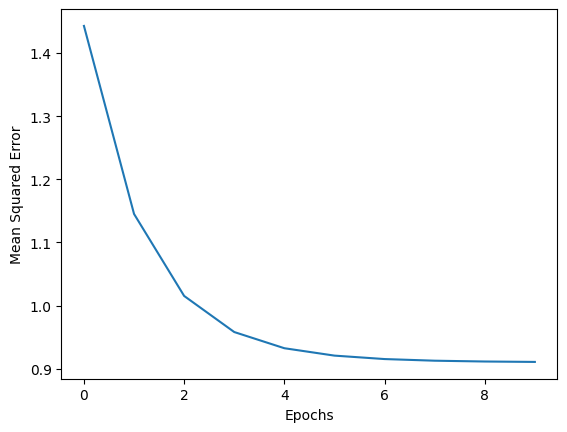

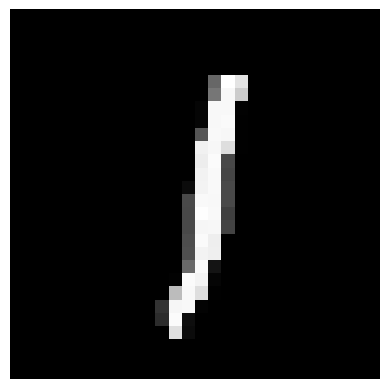

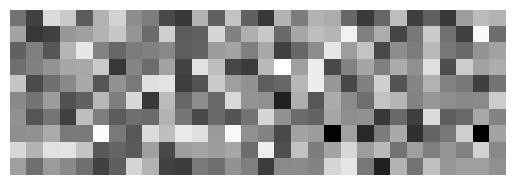

In [201]:
model = FEBAM(image_height * image_width, y_dim, learning_rate)
epochs = 10
losses = []

x0 = image.reshape(1, image_width * image_height)
xt, yt, y0 = model(x0)
model.update_weights(x0, xt, y0, yt)

for _ in range(epochs):
    xt, yt, _ = model(xt)
    model.update_weights(x0, xt, y0, yt)
    loss = torch.mean(torch.square(x0 - xt)).detach().numpy()
    losses.append(loss)

plot_loss(losses, epochs)
plot_image(xt.detach().numpy().reshape(image_height, image_width))
plot_image(yt.detach().numpy().reshape(10, 30))

## Multi-Pattern Learning

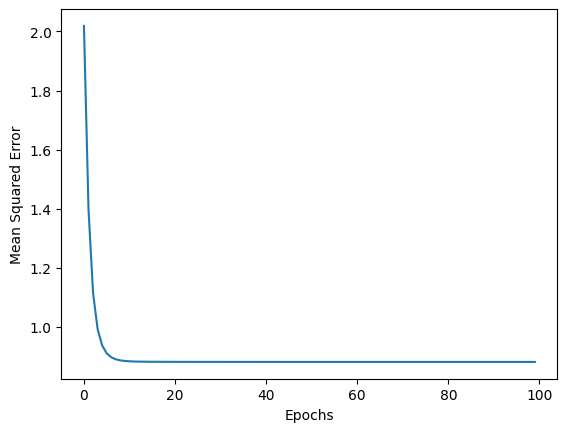

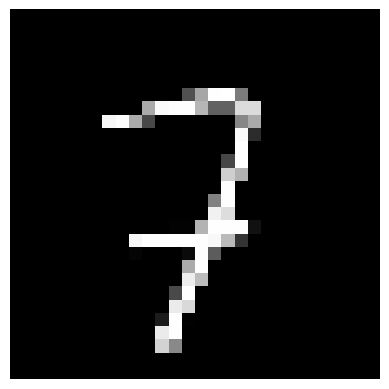

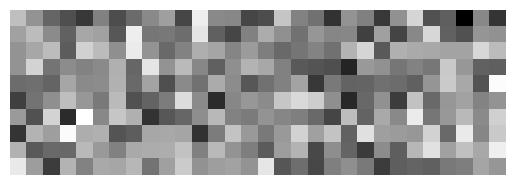

In [206]:
model = FEBAM(image_height * image_width, y_dim, learning_rate)

losses = []
x0_list = []
y0_list = []
xt_list = []
yt_list = []
epochs = 100
num_patterns = 20

for i in range(num_patterns):
    image, _ = next(iter(train_loader))
    x0 = image.reshape(1, 28*28)
    xt, yt, y0 = model(x0)
    x0_list.append(x0)
    y0_list.append(y0)
    xt_list.append(xt)
    yt_list.append(yt)

for j in range(epochs):
    losses_this_epoch = []
    
    for i in range(len(patterns)):
        x0 = x0_list[i]
        y0 = y0_list[i]
        xt, yt, _ = model(xt_list[i])
        model.update_weights(x0, xt, y0, yt)
        
        loss = torch.mean(torch.square(x0 - xt)).detach().numpy()
        losses_this_epoch.append(loss)

    losses.append(sum(losses_this_epoch) / len(losses_this_epoch))

plot_loss(losses, epochs)
plot_image(xt.detach().numpy().reshape(image_height, image_width))
plot_image(yt.detach().numpy().reshape(10, 30))